# **Image Classification Using SVD**  
### **Python Code for Image Classification Using Singular Value Decomposition and Optimization**

#### Authors: * yomna abdelmegeed , nadia Ashraf , monica maged , yara ahmed , hagar atef , menna alla ahmed*

---

### Overview  
This repository contains Python code accompanying our paper:  
[**Image Classification Using Singular Value Decomposition and Optimization**](https://arxiv.org/pdf/2412.07288).

This code demonstrates the implementation of our proposed method for image classification using singular value decomposition (SVD) and optimized categorical representative images.  

---

## Outline of the Code:


1.   Import packages & connect to drive
2.   Image pre-processing
3.   Split data into training and testing
4.   Compute templates with training set
5.   Classification probability distribution and errors with different ranks and norms, testing against optimally weighted template
6.   Norm evaluation at a best rank
7.   Original test images with predicted labels for Fro norm rank 10
8.   Generate subplot showing best rank images for one persian cat and boxer dog test for each norm
9.   Further comparison of optimally weighted template vs average template
10.  Single image experiments



## 1. Import Packages 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage.exposure import equalize_hist
from skimage import io, color
from skimage.transform import rotate
from skimage.transform import resize
from skimage.transform import rescale
from skimage.exposure import adjust_gamma
from sklearn.model_selection import StratifiedShuffleSplit
from numpy.linalg import svd
from scipy.optimize import minimize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## 2. Image Pre-Processing
### Resize and Convert to Grayscale

In [13]:
# Define paths to the folders containing images
boxer_folder = 'boxer'
persian_cat_folder = 'persian_cat'

#image_size = (256, 256)  # Resize all images to this size
image_size = (64, 64) 

# Function to load and preprocess images from a folder
def load_images(folder_path, image_size):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.JPG', '.jpeg')):
            img = io.imread(os.path.join(folder_path, filename))

            # Ensure the image is RGB (3 channels) by removing an alpha channel if it exists
            if img.shape[-1] == 4:
                img = img[..., :3]  # Keep only the first 3 channels (RGB)

            img_gray = color.rgb2gray(img)  # Convert to grayscale
            img_resized = resize(img_gray, image_size)  # Resize
            images.append(img_resized)  # Store resized image
    return np.array(images)  # converts the list of images to a NumPy array

In [14]:
# Function to augment images with rotations/flips and zooms (*4)
def augment_images(images):
    augmented = []
    for img in images:
        augmented.append(img)
        augmented.append(rotate(img, angle=10))
        augmented.append(np.fliplr(img))
        #  zoom by 30%
        zoomed = rescale(img, 1.3, mode='reflect', anti_aliasing=True)
        # crop zoomed image
        center = zoomed.shape[0] // 2
        cropped = zoomed[center - 32:center + 32, center - 32:center + 32]
        augmented.append(cropped)
    return np.array(augmented)
    

# Load images
boxer_images = load_images(boxer_folder, image_size)
persian_cat_images = load_images(persian_cat_folder, image_size)

## 3. Split data into training and testing

In [15]:
all_images = np.concatenate([persian_cat_images, boxer_images])
labels = np.concatenate([np.zeros(len(persian_cat_images)), np.ones(len(boxer_images))])

# Stratified split (preserve class distribution)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)
train_idx, test_idx = next(sss.split(all_images, labels))

# Split data
persian_cat_train = all_images[train_idx][labels[train_idx] == 0]
boxer_train = all_images[train_idx][labels[train_idx] == 1]
persian_cat_test = all_images[test_idx][labels[test_idx] == 0]
boxer_test = all_images[test_idx][labels[test_idx] == 1]

# --- Added: Apply augmentation to training data only ---
boxer_train = augment_images(boxer_train)
persian_cat_train = augment_images(persian_cat_train)
# --------------------------------------------------------

# --- NEW: Shuffle the training data ---
np.random.shuffle(boxer_train)
np.random.shuffle(persian_cat_train)

print("Training and testing split completed:")
print(f"Persian Cat Training: {persian_cat_train.shape}")  # Will show 4x original size
print(f"Persian Cat Testing: {persian_cat_test.shape}")
print(f"Boxer Training: {boxer_train.shape}")              # Will show 4x original size
print(f"Boxer Testing: {boxer_test.shape}")

Training and testing split completed:
Persian Cat Training: (476, 64, 64)
Persian Cat Testing: (51, 64, 64)
Boxer Training: (476, 64, 64)
Boxer Testing: (51, 64, 64)


## 4. Compute templates with training set
### Average template

In [16]:
# Compute the average template for each category
def compute_template(images):
    # Average the images to create a representative template
    avg_image = np.mean(images, axis=0)
    return avg_image

In [17]:
# Compute the average template for each category
boxer_a_template = compute_template(boxer_train)
persian_cat_a_template = compute_template(persian_cat_train)

### Optimized template using SLSQP

In [18]:
# Compute weighted template using optimization
def compute_weighted_template(images, class_name=""):
    # Flatten images to vectors
    flattened_images = images.reshape(images.shape[0], -1)
    N = flattened_images.shape[0]

    # Objective function to minimize reconstruction error for all images
    def objective(weights):
        weights = np.array(weights)
        weighted_avg = np.dot(weights, flattened_images)
        total_error = np.sum([
            np.linalg.norm(flattened_images[i] - weighted_avg)**2 for i in range(N)
        ])
        return total_error

    # Constraints: weights must sum to 1, and each weight >= 0
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights = 1
        {'type': 'ineq', 'fun': lambda w: w}  # Each weight >= 0
    ]
    initial_weights = np.ones(N) / N  # Uniform initialization

    # Solve the optimization problem
    result = minimize(objective, initial_weights, constraints=constraints)
    optimized_weights = result.x

    # Compute the weighted template
    weighted_template = np.dot(optimized_weights, flattened_images).reshape(image_size)
    print(f"\nCompare the Weighted and Average Template for {class_name}")
    print("Sum of difference of weights: ")
    print(np.sum(optimized_weights - initial_weights))

    return weighted_template

In [19]:
# Compute the weighted average template for each category
boxer_weighted_template = compute_weighted_template(boxer_train, "Boxer Dog")
persian_cat_weighted_template = compute_weighted_template(persian_cat_train, "Persian Cat")


Compare the Weighted and Average Template for Boxer Dog
Sum of difference of weights: 
-4.85722573273506e-17

Compare the Weighted and Average Template for Persian Cat
Sum of difference of weights: 
-5.074066167232161e-17


##### The above analysis shows the average and optimally weighted template are almost the same and thus we will arbitrarily continue the rest of the analysis with the optimally weighted template.

## 5. Classification Probability Distribution and Errors with Different Ranks and Norms, Testing Against Optimally Weighted Template

### Function to compute low rank approximations of the test sets

In [20]:
def test_k_approx(rank, test_images):
   new_test_images = np.zeros(test_images.shape)


   for i in range(test_images.shape[0]):
     test_img = test_images[i]
     # Compute low-rank approximation of the test image
     U, S, VT = svd(test_img, full_matrices=False)
     U_k = U[:, :rank]
     S_k = np.diag(S[:rank])
     VT_k = VT[:rank, :]
     test_img_approx = np.dot(U_k, np.dot(S_k, VT_k))


     new_test_images[i] = test_img_approx

   return new_test_images

### Function to store the classification margin and errors when comparing the categorical template to the low rank approximation of the test set, iterating on rank of the test images

In [21]:
def generate_rank_pred(test1, test2, temp1, temp2, rank, order = np.inf):
  # Initialize matrices with zeros
  E11 = np.zeros((test1.shape[0], rank))
  E12 = np.zeros((test1.shape[0], rank))
  E21 = np.zeros((test2.shape[0], rank))
  E22 = np.zeros((test2.shape[0], rank))

  pred1 = np.zeros((test1.shape[0], rank))
  pred2 = np.zeros((test2.shape[0], rank))

  for r in range(rank):
    test1_k = test_k_approx(r+1, test1)
    test2_k = test_k_approx(r+1, test2)
    for i in range(test1_k.shape[0]):
      E11[i,r] = np.linalg.norm(test1_k[i] - temp1, ord = order)
      E12[i,r] = np.linalg.norm(test1_k[i] - temp2, ord = order)
      # Predict category based on smallest error
      if E11[i,r] < E12[i,r]:
        pred1[i,r] = 1
      else:
        pred1[i,r] = 0
    for i in range(test2_k.shape[0]):
      E21[i,r] = np.linalg.norm(test2_k[i] - temp1, ord = order)
      E22[i,r] = np.linalg.norm(test2_k[i] - temp2, ord = order)
      # Predict category based on smallest error
      if E22[i,r] < E21[i,r]:
        pred2[i,r] = 1
      else:
        pred2[i,r] = 0

    # Compute average along the columns, across the rows of images in each set
    E11_mean = np.mean(E11, axis = 0) # shape should be 1 x rank
    E12_mean = np.mean(E12, axis = 0)
    E21_mean = np.mean(E21, axis = 0)
    E22_mean = np.mean(E22, axis = 0)

    assert E11_mean.shape == (rank,), f"E11_mean shape expected to be {rank}, but got {E11_mean.shape}"

    assert E12_mean.shape == (rank,), f"E12_mean shape expected to be {rank}, but got {E12_mean.shape}"

    assert E21_mean.shape == (rank,), f"E21_mean shape expected to be {rank}, but got {E21_mean.shape}"

    assert E22_mean.shape == (rank,), f"E22_mean shape expected to be {rank}, but got {E22_mean.shape}"

  return E11_mean, E12_mean, E21_mean, E22_mean, pred1, pred2


### Function to plot the prediction probability vs rank for a given norm

In [22]:
def plot_prediction_probability(pred1, pred2, title):
    """Plots prediction probability vs rank.

    Args:
        pred1: A NumPy array (n_images, n_ranks) of predictions for the first class.
        pred2: A NumPy array (n_images, n_ranks) of predictions for the second class.
    """

    n_ranks = pred1.shape[1]
    ranks = np.arange(1, n_ranks+1) # 1 to len(n_ranks)

    prob1 = np.sum(pred1, axis=0) / pred1.shape[0] # sums across the columns
    prob2 = np.sum(pred2, axis=0) / pred2.shape[0]
    avgprob = (prob1 + prob2) / 2 # 1 by k rank array

    # Identify maximum average point
    max_value = np.max(avgprob)
    max_index = np.argmax(avgprob) + 1

    plt.figure(figsize=(10, 6))
    plt.plot(ranks, prob1, label='Boxer Dog', marker='o', color="green")
    plt.plot(ranks, prob2, label='Persian Cat', marker='o', color="orange")
    plt.plot(ranks, avgprob, label='Average', marker='x', color="black")

    # Plot maximum average point
    plt.plot(max_index, max_value, 'ro', label=f'Maximum ({max_index}, {max_value:.2f})')

    plt.xlabel("Rank", fontsize=20)
    plt.ylabel("Prediction Probability", fontsize=20)
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

    return max_index

### Function to plot the error vs rank for a given norm

In [24]:
def plot_errorvsrank(E11_w_mean, E12_w_mean, E21_w_mean, E22_w_mean, ord):
  n_ranks = len(E11_w_mean)
  ranks = range(1, n_ranks+1) # 1 to len(n_ranks)

  plt.figure(figsize=(6, 4))
  plt.plot(ranks, E11_w_mean, label='Error with Boxer Dog Template', color = 'green')
  plt.plot(ranks, E12_w_mean, label='Error with Persian Cat Template', color = 'lime')
  plt.xlabel("Rank", fontsize=15)
  plt.ylabel("Error", fontsize=15)
  plt.title(f"Boxer Dog Test Images vs Rank for Norm: {ord}", fontsize=16)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.grid(True)
  plt.legend(fontsize=13)
  plt.show()

  plt.figure(figsize=(6, 4))
  plt.plot(ranks, E21_w_mean, label='Error with Boxer Dog Template', color = 'orangered')
  plt.plot(ranks, E22_w_mean, label='Error with Persian Cat Template', color = 'orange')
  plt.xlabel("Rank", fontsize=15)
  plt.ylabel("Error", fontsize=15)
  plt.title(f"Persian Cat Test Images vs Rank for Norm: {ord}", fontsize=16)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.grid(True)
  plt.legend(fontsize=13)
  plt.show()

### Function to generate test and pred for confusion matrix

In [25]:
def generate_test_pred(pred1, pred2):
    # Initialize y_test arrays
    y_test1 = np.ones_like(pred1)  # Actual is Class 1
    y_test2 = np.full_like(pred2, 2)  # Actual is Class 2

    # Generate pred_one and pred_two
    pred_one = np.where(pred1 == 1, 1, 2)  # Class 1 if pred1 == 1, else Class 2
    pred_two = np.where(pred2 == 1, 2, 1)  # Class 2 if pred2 == 1, else Class 1

    # Combine predictions and ground truth
    pred = np.concatenate((pred_one, pred_two))
    y_test = np.concatenate((y_test1, y_test2))

    return pred, y_test

### Function to generate confusion matrix

In [26]:
def generate_confusion_matrix(y_test, pred, fixed_rank, ord):
    # Generate and plot confusion matrix
    conf_matrix = confusion_matrix(y_test, pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="YlGnBu",
        cbar=False,
        xticklabels=["Boxer Dog", "Persian Cat"],
        yticklabels=["Boxer Dog", "Persian Cat"],
        linewidths=0.5,
        linecolor="black",
        annot_kws={"fontsize": 13, "weight": "bold"}
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(f"Confusion Matrix for fixed rank = {fixed_rank}, and norm = {ord}", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.show()

### Iterate on the norms and produce results from functions

#### Analysis with training set

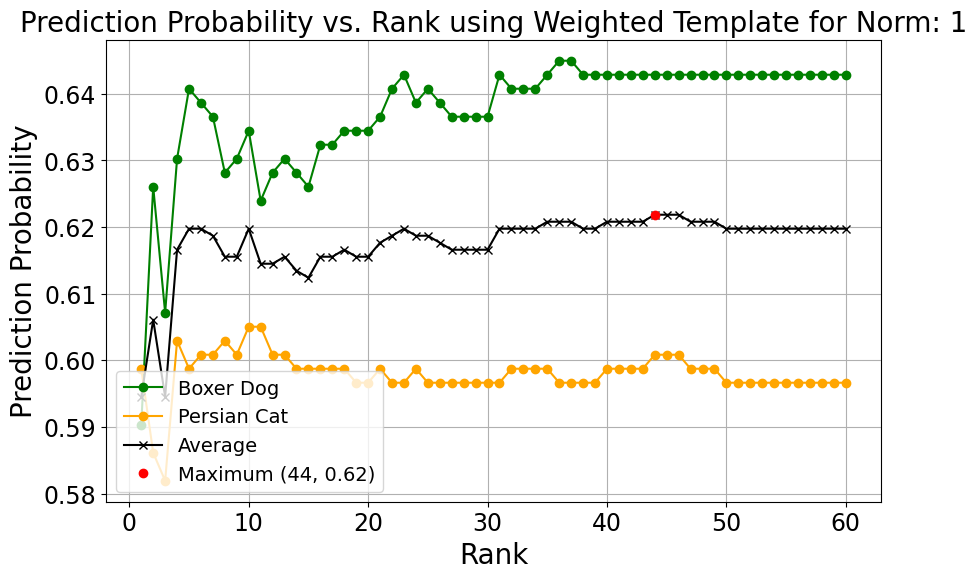

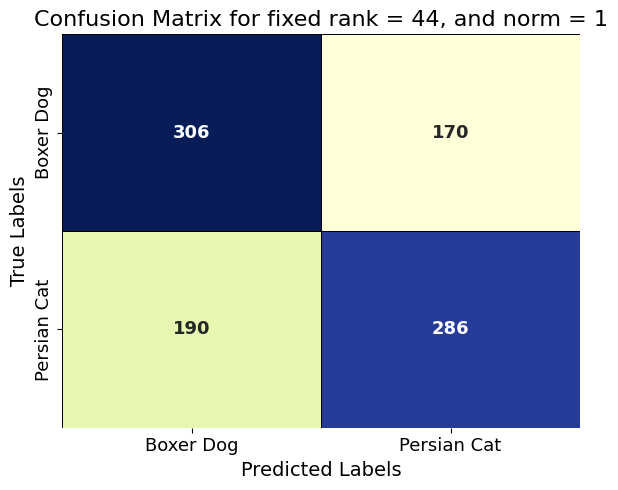

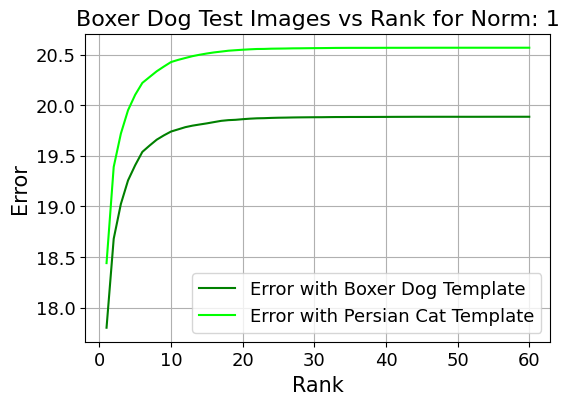

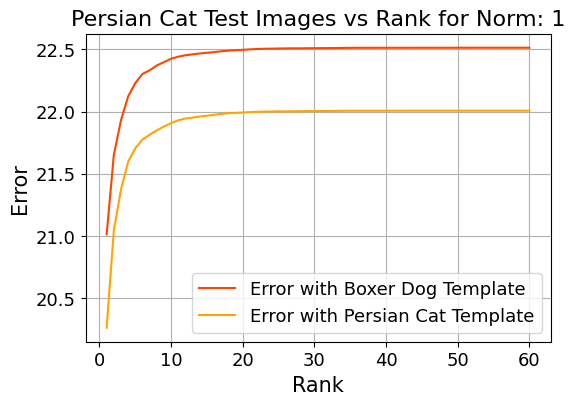

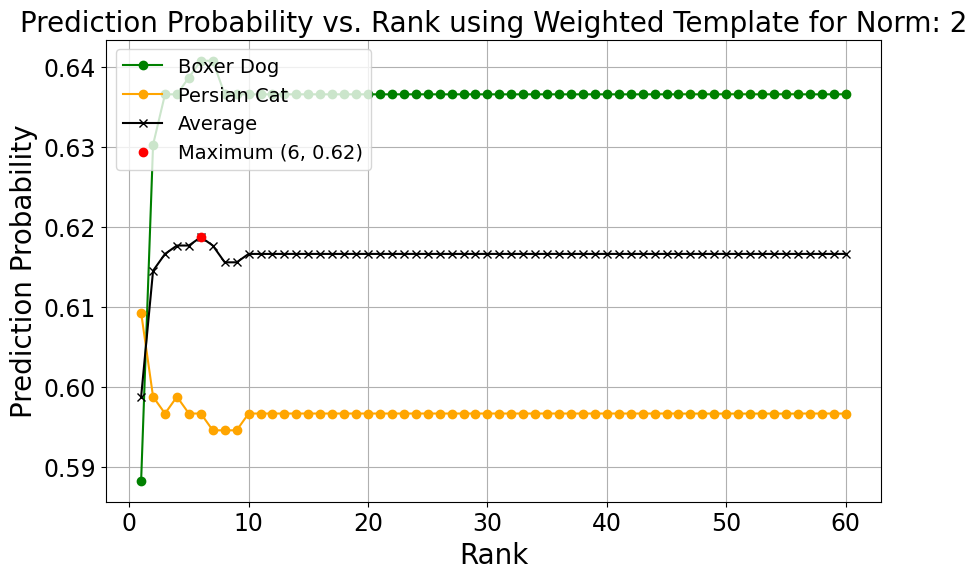

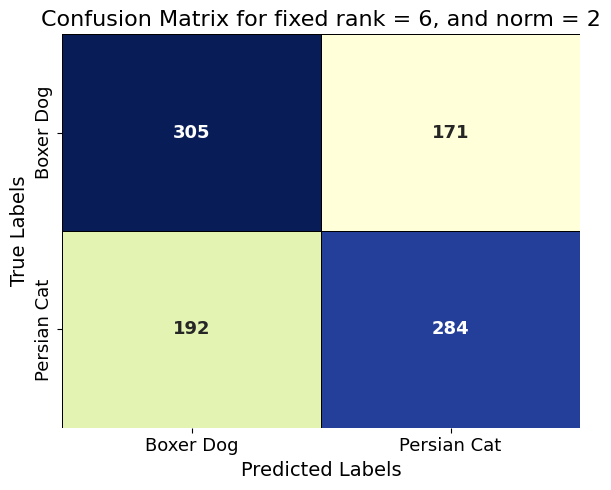

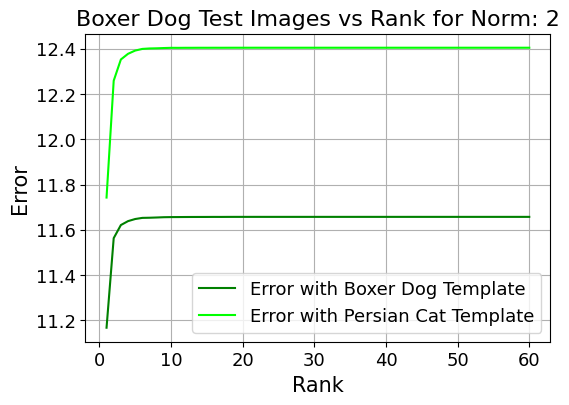

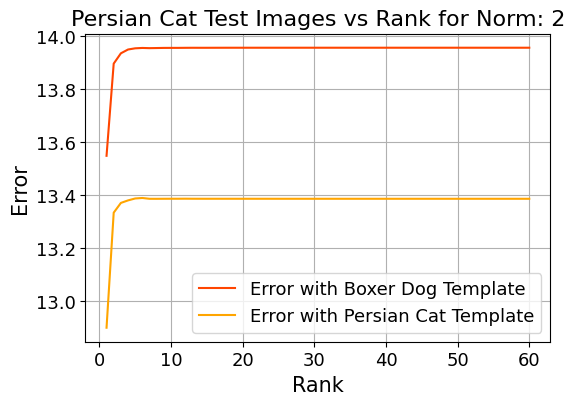

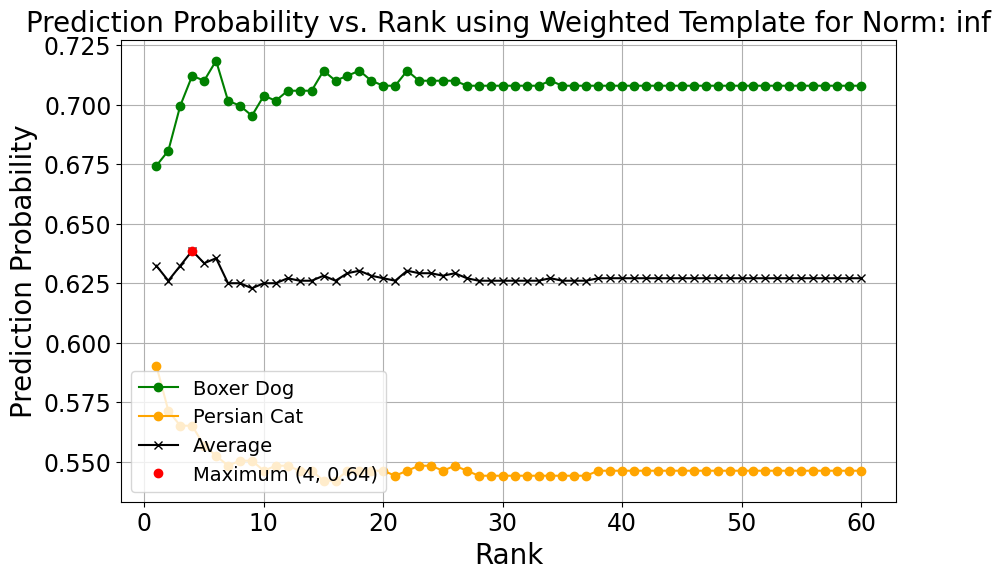

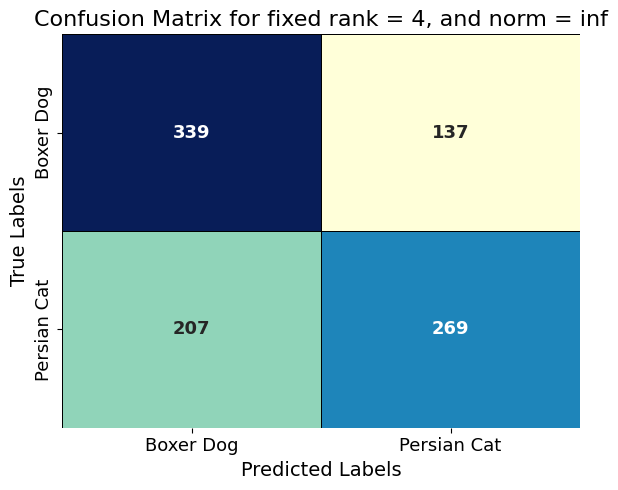

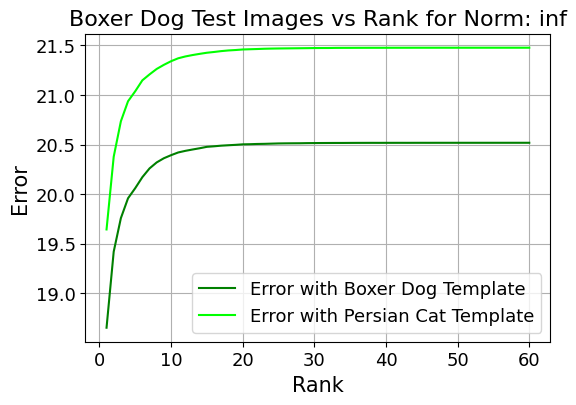

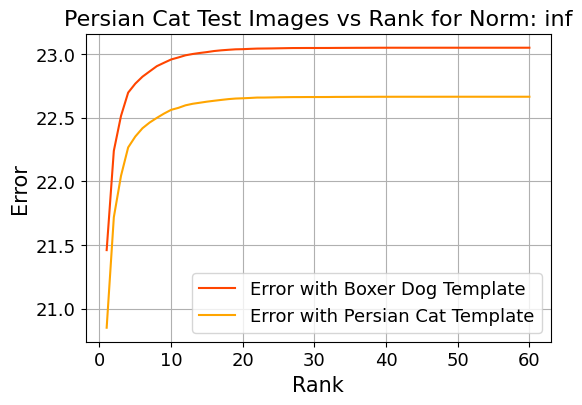

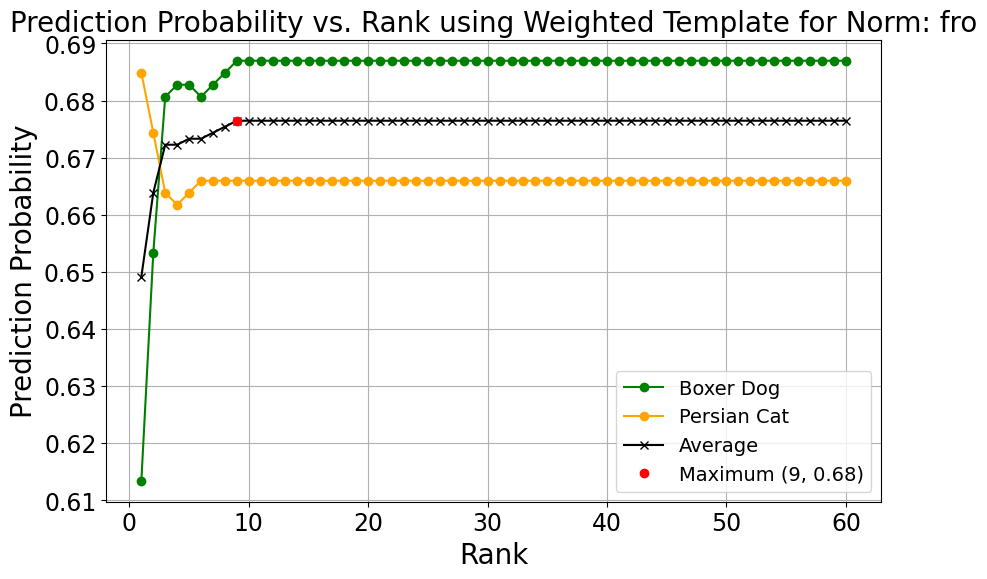

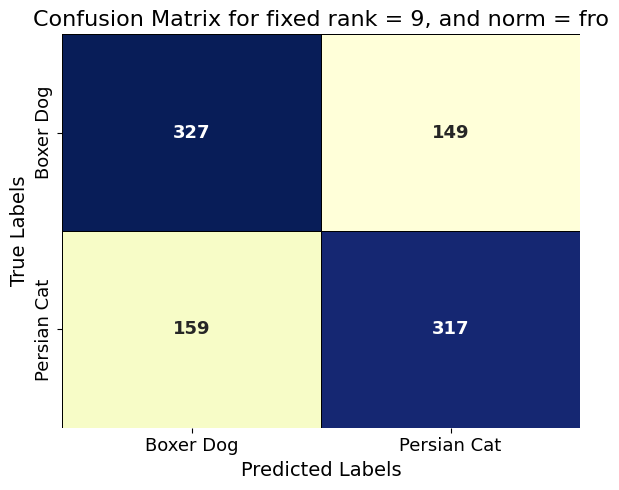

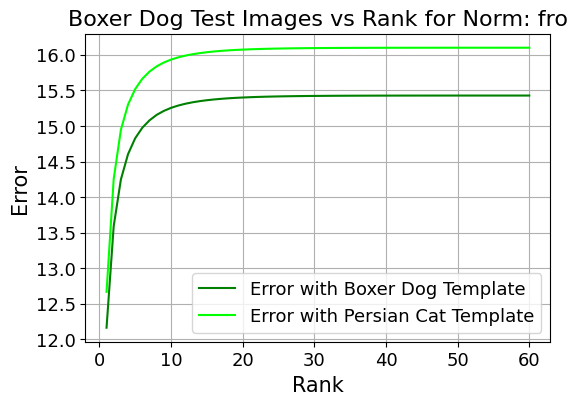

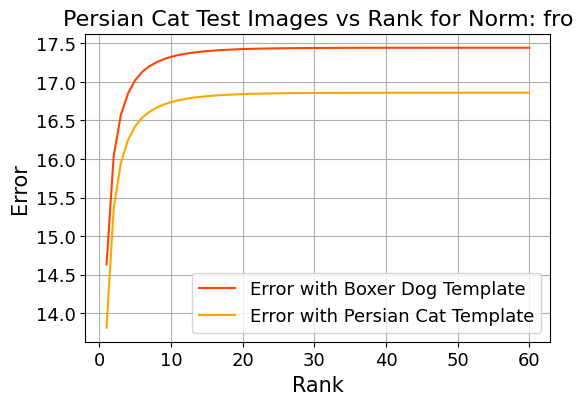

In [27]:
# Initialize recalls dictionary with accuracy
metrics = {'1': {'TP Recall': [], 'FP Recall': [], 'Accuracy': []},
           '2': {'TP Recall': [], 'FP Recall': [], 'Accuracy': []},
           'inf': {'TP Recall': [], 'FP Recall': [], 'Accuracy': []},
           'fro': {'TP Recall': [], 'FP Recall': [], 'Accuracy': []}}

for ord in [1,2,np.inf,'fro']:
  E11_w_mean, E12_w_mean, E21_w_mean, E22_w_mean, pred1_w, pred2_w = generate_rank_pred(test1=boxer_train, test2=persian_cat_train, temp1=boxer_weighted_template, temp2=persian_cat_weighted_template, rank = 60, order = ord)
  fixed_rank = plot_prediction_probability(pred1_w, pred2_w, title = f"Prediction Probability vs. Rank using Weighted Template for Norm: {ord}") # this is where we specify that class 1 is boxer, class 2 is persian cat

  # Generate pred and y_test arrays
  pred1 = pred1_w[:,fixed_rank-1]
  pred2 = pred2_w[:,fixed_rank-1]
  pred, y_test = generate_test_pred(pred1, pred2)

  # Generate and plot confusion matrix
  generate_confusion_matrix(y_test, pred, fixed_rank, ord)

  # Generate classification report
  class_report = classification_report(y_test, pred, target_names=['Boxer Dog', 'Persian Cat'], output_dict=True)

  # Map np.inf to 'inf' for dictionary key compatibility
  ord_key = 'inf' if ord == np.inf else str(ord)

  # Store recalls and accuracy
  metrics[ord_key]['TP Recall'].append(class_report['Boxer Dog']['recall'])
  metrics[ord_key]['FP Recall'].append(1 - class_report['Boxer Dog']['recall'])  # False positive recall is 1 - TP Recall
  metrics[ord_key]['Accuracy'].append(class_report['accuracy'])  # Store accuracy

  # Display results
  plot_errorvsrank(E11_w_mean, E12_w_mean, E21_w_mean, E22_w_mean, ord)

#### Based on the above results we will continue the analysis with a best rank for each norm as follows:
| Norm  | Rank (Testing Set) | Rank (Training Set) |
|-------|---------------------|---------------------|
| 1     | 4                   | 44                |
| 2     | 2                   | 6                  |
| inf   | 1                   | 4                  |
| fro   | 9                   | 9                  |




In [ ]:
# Define orders and ranks for testing
orders = [1, 2, np.inf, 'fro']
test_ranks = [4, 2, 1, 9]      # Testing set best ranks
train_ranks = [44, 6, 4, 9]   # Training set best ranks (from your analysis)
ranks = train_ranks            # Use training ranks for consistency

## 6. Norm Evaluation at a Best Rank

#### Function for error and pred generation at a best rank

In [28]:
def generate_rank_norm(test1, test2, temp1, temp2, rank, order):
  # Initialize matrices with zeros
  E11 = np.zeros((test1.shape[0]))
  E12 = np.zeros((test1.shape[0]))
  E21 = np.zeros((test2.shape[0]))
  E22 = np.zeros((test2.shape[0]))

  pred1 = np.zeros((test1.shape[0]))
  pred2 = np.zeros((test2.shape[0]))

  test1_k = test_k_approx(rank, test1)
  test2_k = test_k_approx(rank, test2)
  for i in range(test1_k.shape[0]):
    E11[i] = np.linalg.norm(test1_k[i] - temp1, ord = order)
    E12[i] = np.linalg.norm(test1_k[i] - temp2, ord = order)
    # Predict category based on smallest error
    if E11[i] < E12[i]:
      pred1[i] = 1
    else:
      pred1[i] = 0

  for i in range(test2_k.shape[0]):
    E21[i] = np.linalg.norm(test2_k[i] - temp1, ord = order)
    E22[i] = np.linalg.norm(test2_k[i] - temp2, ord = order)
    # Predict category based on smallest error
    if E22[i] < E21[i]:
      pred2[i] = 1
    else:
      pred2[i] = 0

  return E11, E12, E21, E22, pred1, pred2

### Bar Plot with TP and FP Recalls & Accuracy

In [ ]:
# Modified bar chart to include values on all bars
fig, ax = plt.subplots(figsize=(12, 8))

# Define x-axis labels and positions
x_labels = ['1', '2', 'inf', 'fro']
x = np.arange(len(x_labels))
width = 0.25  # Narrower bar width to accommodate three bars per group

# Extract TP recalls, FP recalls, and accuracy
tp_recalls = [np.mean(metrics[ord_key]['TP Recall']) for ord_key in x_labels]
fp_recalls = [np.mean(metrics[ord_key]['FP Recall']) for ord_key in x_labels]
accuracies = [np.mean(metrics[ord_key]['Accuracy']) for ord_key in x_labels]

# Plot bars
tp_bars = ax.bar(x - width, tp_recalls, width, label='TP Recall', alpha=0.8, color='green')
fp_bars = ax.bar(x, fp_recalls, width, label='FP Recall', alpha=0.8, color='orange')
accuracy_bars = ax.bar(x + width, accuracies, width, label='Accuracy', alpha=0.8)

# Add values on top of each bar
for bars, values in zip([tp_bars, fp_bars, accuracy_bars], [tp_recalls, fp_recalls, accuracies]):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{value:.2f}",
            ha='center', va='bottom', fontsize=17,
        )

ax.set_xlabel('Norms', fontsize=25)
ax.set_ylabel('Metrics', fontsize=25)
ax.set_title('TP Recall, FP Recall, and Accuracy vs Norms', fontsize=24, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

# Move legend to the bottom
ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()
